<a href="https://colab.research.google.com/github/Yaalht/IA-Cellule/blob/main/le_vrai_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P2 : Estimation durée de vie résiduelle d'une batterie

**Nettoyage et Exploration des Données :**

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LECTURE DU FICHIER

from google.colab import drive
drive.mount('/content/drive')
f = pd.read_csv('/content/drive/MyDrive/Battery_RUL.csv')

f.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


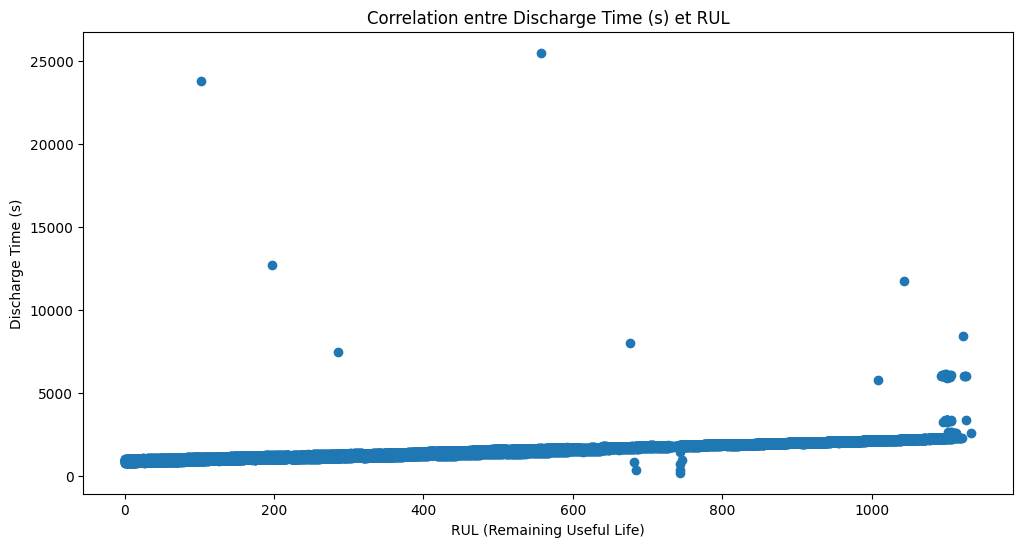

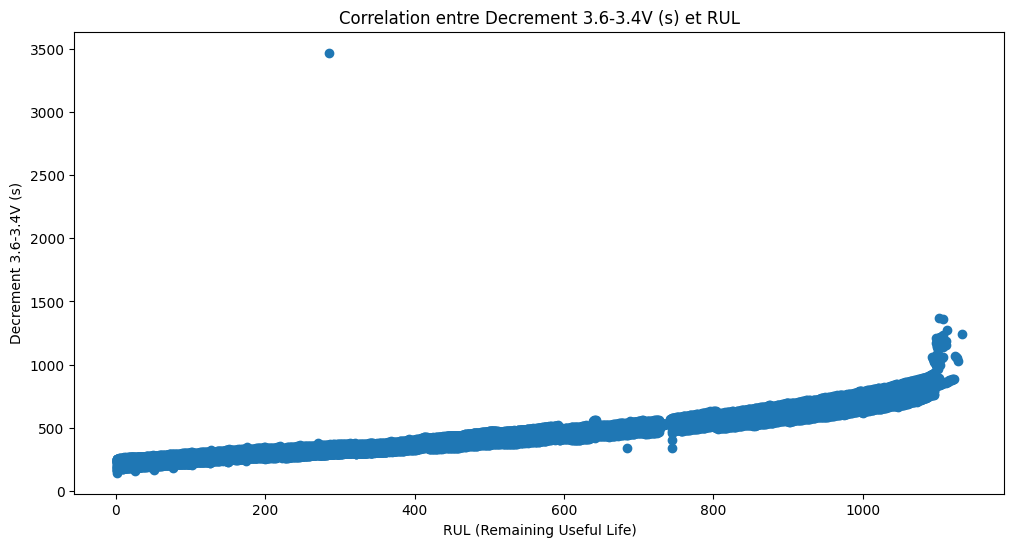

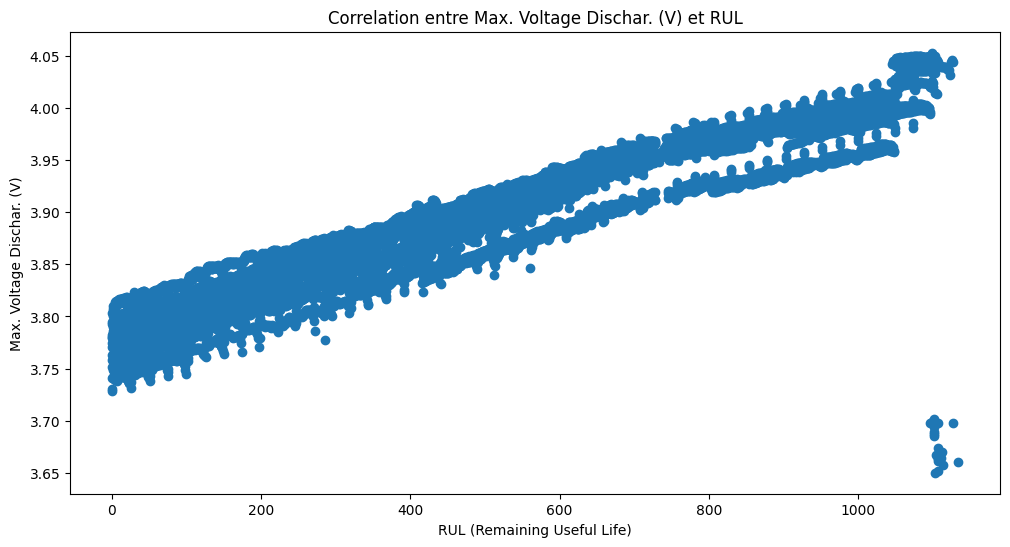

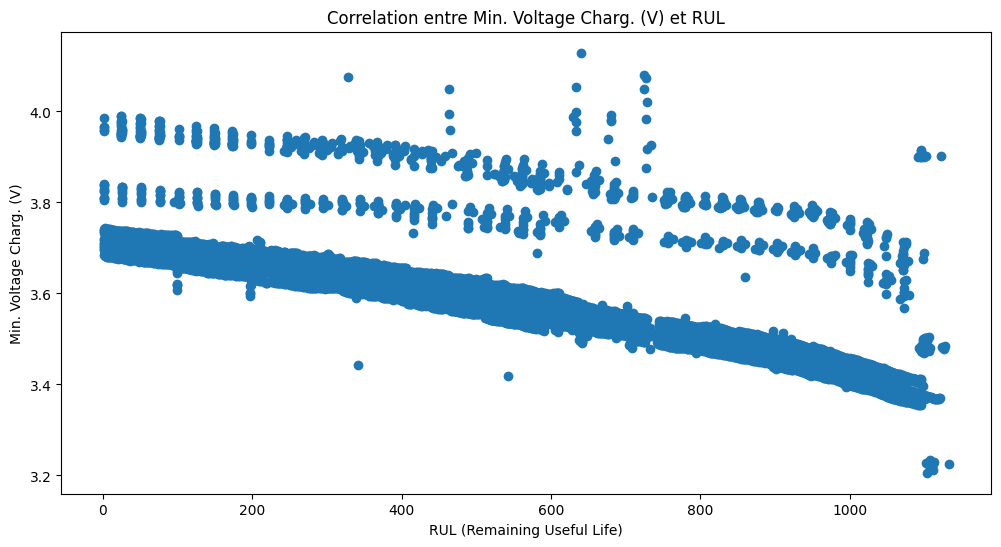

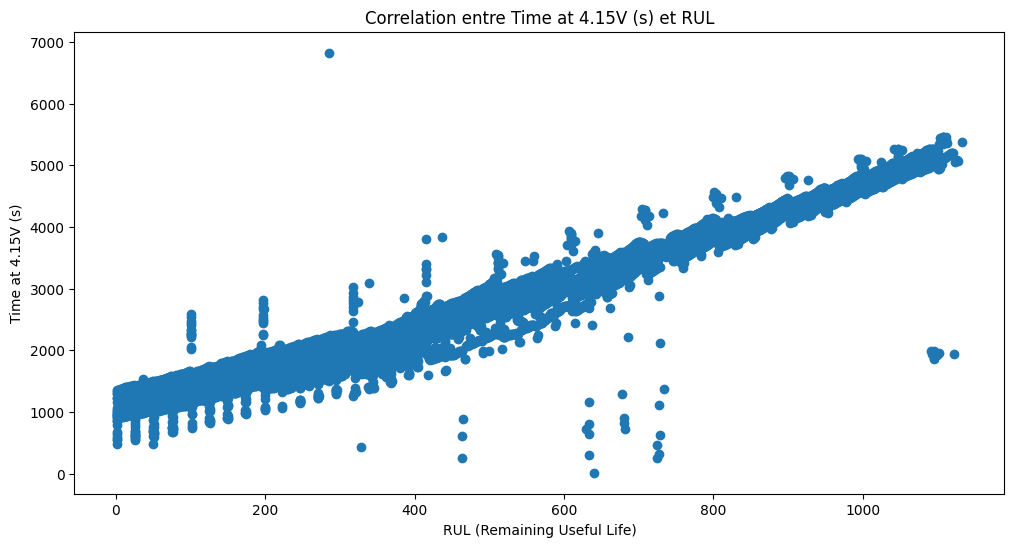

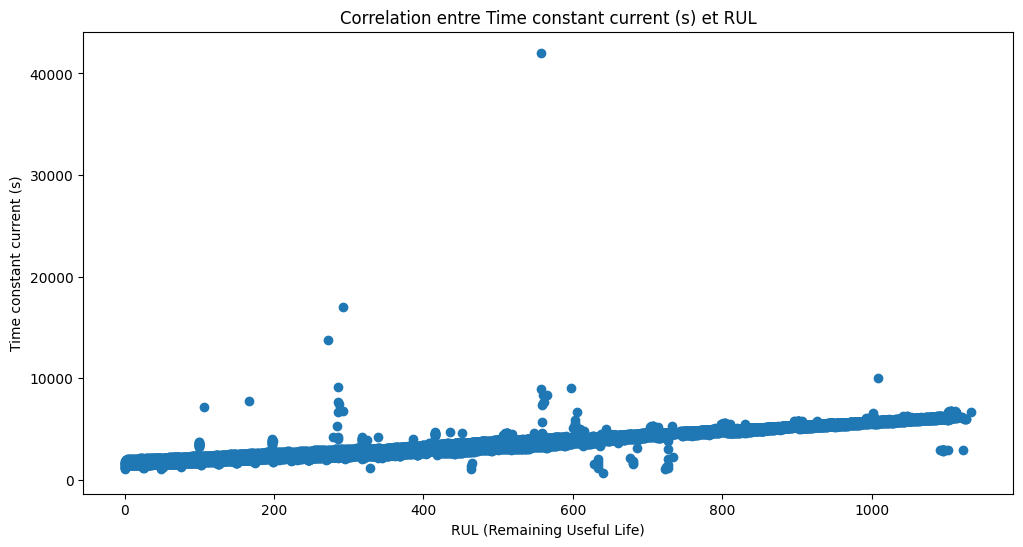

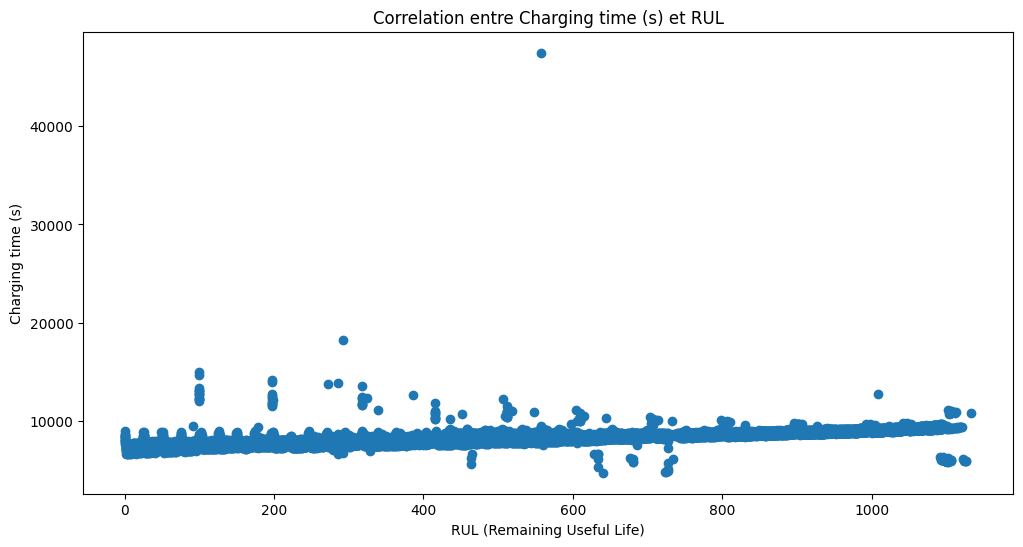

In [34]:
f = f[(f.iloc[:, 1] > 0) & (f.iloc[:, 1] <= 72000)] # On supprime les données si le temps de décharge est inférieur à 0 secondes ou supérieur à 20 heures.
f = f[(f.iloc[:, 2] >= 0)] # On supprime les temps négatifs
f = f[(f.iloc[:, 3] >= 3) & (f.iloc[:, 3] <= 4.2)] # On garde uniquement les valeurs de tension comprises entre 3V et 4.2V
f = f[(f.iloc[:, 4] >= 3) & (f.iloc[:, 4] <= 4.2)] # On garde uniquement les valeurs de tension comprises entre 3V et 4.2V
f = f[(f.iloc[:, 5] >= 0) & (f.iloc[:, 5] <= (f.iloc[:, 1] + f.iloc[:, 7]))] # On supprime les temps négatifs, le temps ne peut pas excéder la durée du cycle
f = f[(f.iloc[:, 6] >= 0) & (f.iloc[:, 6] <= (f.iloc[:, 1] + f.iloc[:, 7]))] # On supprime les temps négatifs, le temps ne peut pas excéder la durée du cycle
f = f[(f.iloc[:, 7] >= 0)] # On supprime les temps négatifs

# Etude des corrélations entre les mesures et le RUL (Remaining Useful Life)
for column in f.columns[1:-1]:  # Exclut la première et la dernière colonne
    plt.figure(figsize=(12, 6))
    plt.scatter(f['RUL'], f[column])

    # Mettre le nom de la colonne dans le ylabel
    plt.ylabel(column)  # Utilise le nom de la colonne pour le ylabel
    plt.xlabel('RUL (Remaining Useful Life)')

    # Afficher le graphique
    plt.title(f'Correlation entre {column} et RUL')
    plt.show()

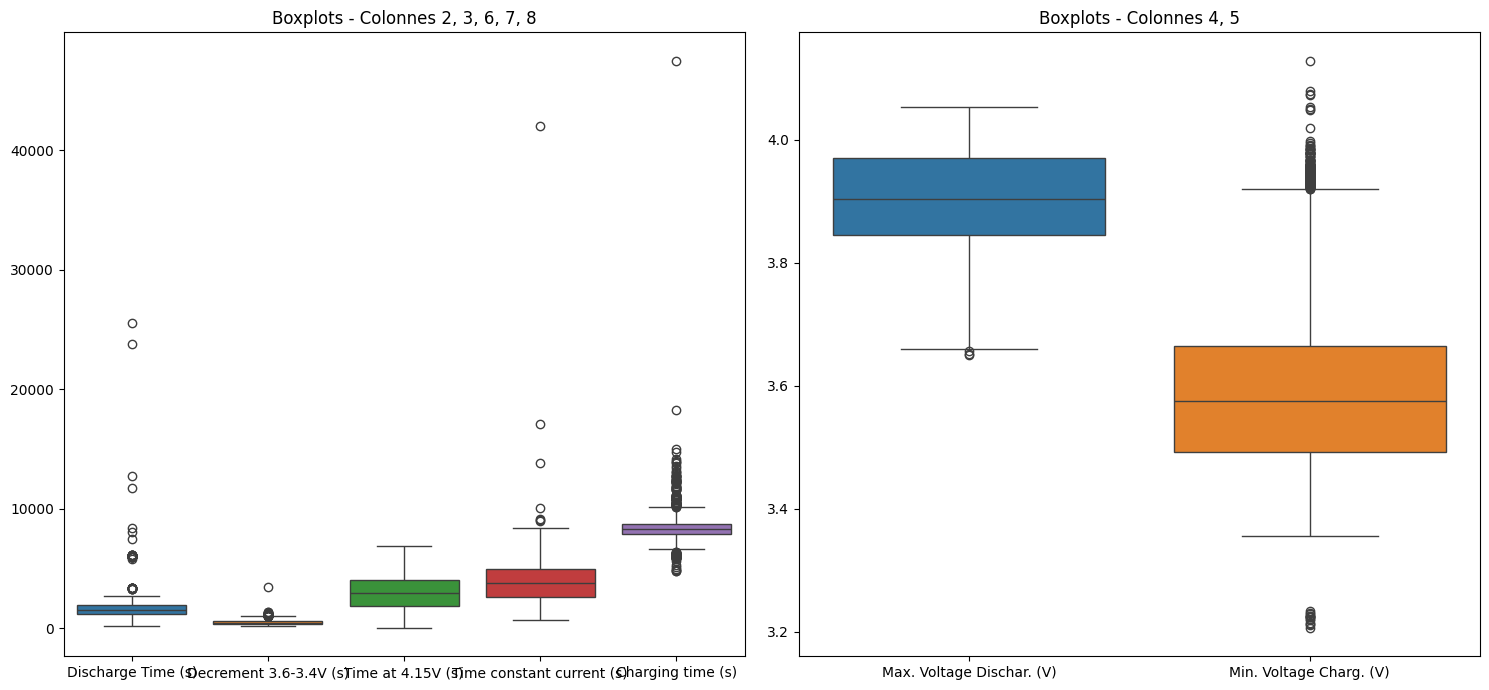

In [35]:
# On sépare les volts et les secondes
cols_1 = f.columns[[1, 2, 5, 6, 7]]  # Colonnes 2, 3, 6, 7, 8
cols_2 = f.columns[[3, 4]]  # Colonnes 4, 5

# Créer une figure pour les boxplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Tracer les boxplots pour les colonnes 2, 3, 6, 7, 8
sns.boxplot(data=f[cols_1], ax=axs[0])
axs[0].set_title('Boxplots - Colonnes 2, 3, 6, 7, 8')

# Tracer les boxplots pour les colonnes 4, 5
sns.boxplot(data=f[cols_2], ax=axs[1])
axs[1].set_title('Boxplots - Colonnes 4, 5')

# Afficher les boxplots
plt.tight_layout()
plt.show()

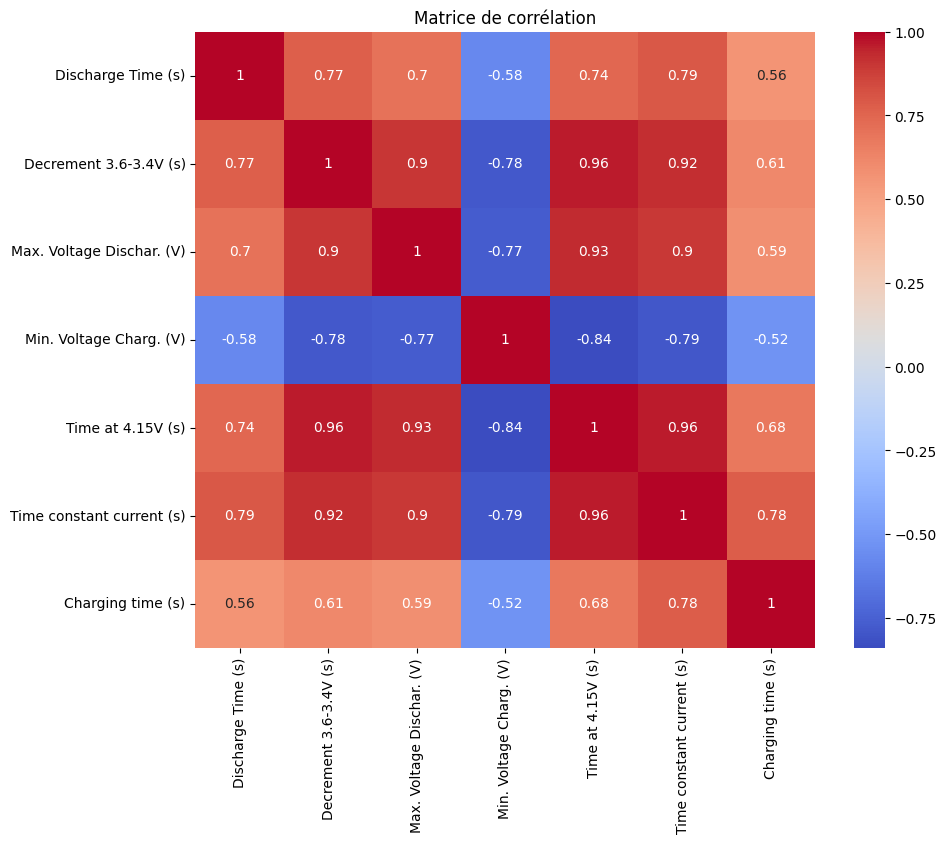

In [36]:
f_subset = f.iloc[:, 1:8]

corr_matrice = f_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrice, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


**Feature Engineering :**

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

f.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL,Charge_Discharge_Ratio,Voltage_Difference,Discharge_Rate,Charge_Rate,Voltage_Ratio
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112,4.152822,0.459,0.384204,1.59553,1.142946
5,7.0,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106,1.810680,0.170,0.552279,1.00000,1.048516
6,8.0,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105,1.002057,0.512,0.997947,1.00000,1.146244
7,9.0,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104,1.001850,0.513,0.998153,1.00000,1.146530
8,10.0,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103,1.001593,0.513,0.998410,1.00000,1.146530


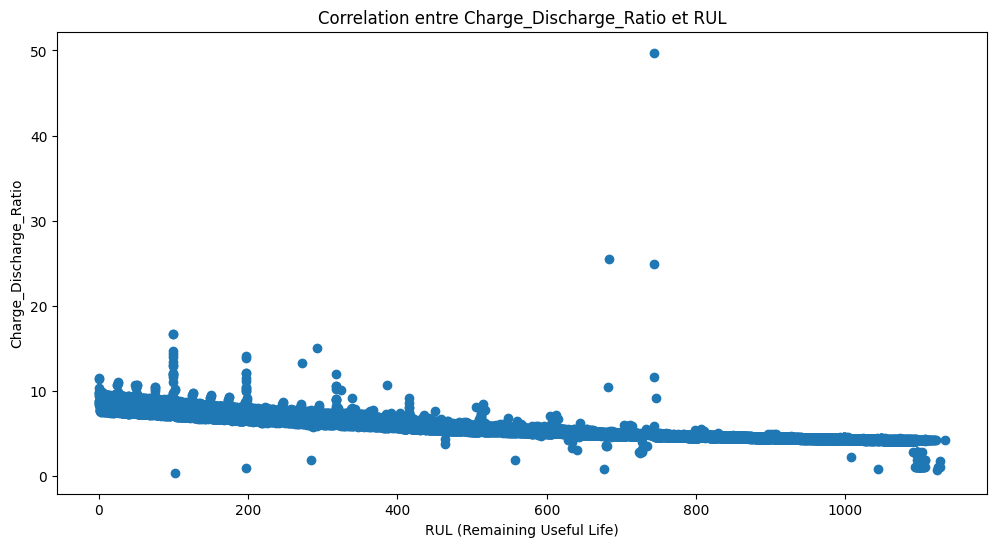

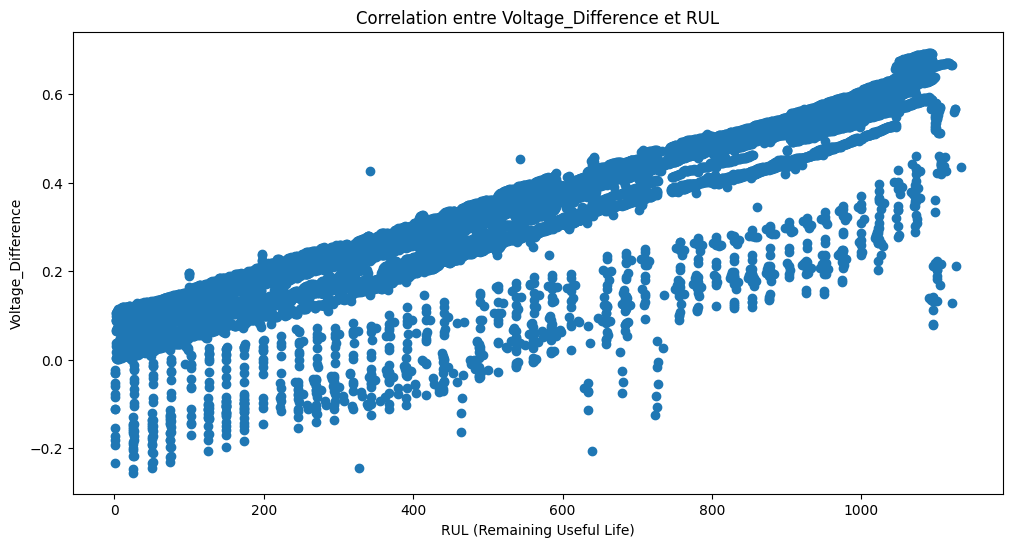

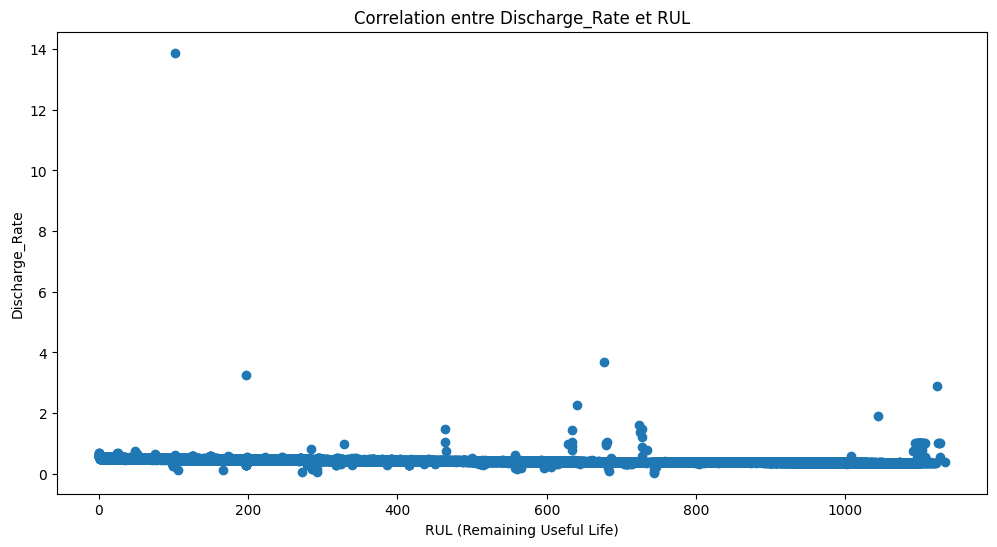

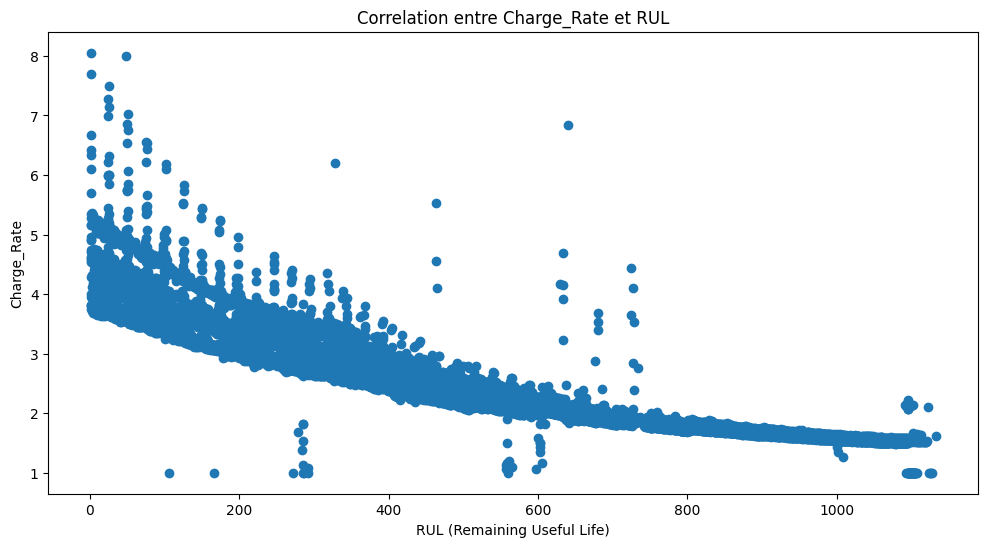

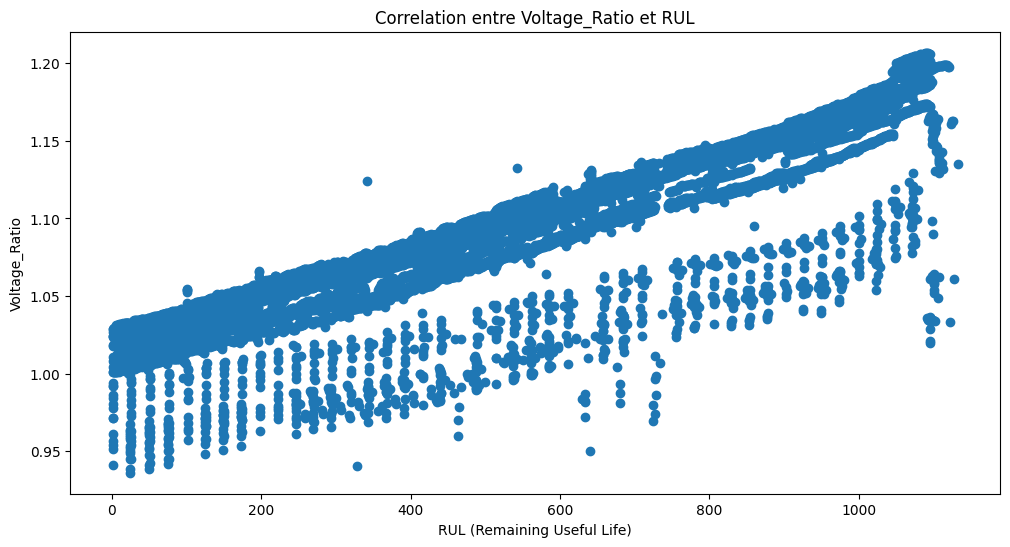

In [44]:
# Création de nouvelles variables
f["Charge_Discharge_Ratio"] = f["Charging time (s)"] / f["Discharge Time (s)"]
f["Voltage_Difference"] = f["Max. Voltage Dischar. (V)"] - f["Min. Voltage Charg. (V)"]
f["Discharge_Rate"] = f["Discharge Time (s)"] / f["Time constant current (s)"]
f["Charge_Rate"] = f["Charging time (s)"] / f["Time constant current (s)"]
f["Voltage_Ratio"] = f["Max. Voltage Dischar. (V)"] / f["Min. Voltage Charg. (V)"]

# Normalisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(f)

# Application de la PCA (conservant 95% de la variance)
pca = PCA(n_components=0.95)
f_pca = pca.fit_transform(df_scaled)

# Conversion en DataFrame final
columns_pca = [f"PC{i+1}" for i in range(f_pca.shape[1])]
f_pca = pd.DataFrame(f_pca, columns=columns_pca)

# Sauvegarde des données transformées
f_pca.to_csv("transformed_data.csv", index=False)

# Etude des corrélations entre les mesures et le RUL (Remaining Useful Life)
for column in f.columns[9:len(f)]:  # Exclut la première et la dernière colonne
    plt.figure(figsize=(12, 6))
    plt.scatter(f['RUL'], f[column])

    # Mettre le nom de la colonne dans le ylabel
    plt.ylabel(column)  # Utilise le nom de la colonne pour le ylabel
    plt.xlabel('RUL (Remaining Useful Life)')

    # Afficher le graphique
    plt.title(f'Correlation entre {column} et RUL')
    plt.show()


**Suppression des lignes contenant des cases vides et feature engineering**